### Visualize the Cn2 Map

In [16]:
import numpy as np
import cv2
from glob import glob
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
plt.rcParams['figure.figsize'] = [15, 8]

In [17]:
def imgradient(img):
    if type(img) != np.ndarray:
        img = img.convert('L')
        img = np.asarray(img)

    sobel_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
    sobel_y = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])
    Gx = cv2.filter2D(img, -1, sobel_x)
    Gy = cv2.filter2D(img, -1, sobel_y)
    grad_mag = np.sqrt(Gx**2 + Gy**2)
    return grad_mag

### Define your parameters


In [18]:
focal_length, fstop = 0.5, 8.000
D, ImageScalledDown, lambda_temp, L = focal_length/fstop, 3, 500E-9, 2789
dx, dy = ImageScalledDown*0.003208/1000, ImageScalledDown*0.003208/1000
PFOV, l_0, L_0 = dx/np.array(focal_length), 1 / 1000, 80
P = 2.914 if D < np.sqrt(lambda_temp * L) and l_0 <= D < L_0 else 1.1
print(f'{PFOV=}, {D=}, {L=}, {P=}')

PFOV=1.9248000000000003e-05, D=0.0625, L=2789, P=1.1


### Load the video

In [19]:
# Define your video path and load the video
path = "Stabilized Road.mp4"
cap = cv2.VideoCapture(path)

video = []
while(True):
    ret, frame = cap.read()
    if ret: 
        video.append(frame)
    else:
        break 
cap.release()
video = np.array(video)

crop = False
if crop:
    x, y = 540, 200
    h, w = 200, 200
    video = video[100:120, y:y+h, x:x+w, :]
else:
    video = video[100:120, :, :, :]

print(f'{video.shape=}')

video.shape=(20, 1080, 1920, 3)


### Estimate the $C_n^2$ Map

In [20]:
sigma_I = np.std(video, axis=0)
Grad_mag = imgradient(video[0])
Grad_mag[Grad_mag < Grad_mag.max()/100] = np.nan
Cn_sqr_mn = np.divide((np.dot(PFOV**2, D**(1/3)) * sigma_I**2), (Grad_mag*float(L)*float(P)))

# Get the mean of the Cn2 map - Not Essential
cn2_pred =  np.nanmean(Cn_sqr_mn)
print(f'{cn2_pred=}')

cn2_pred=1.7899756679056617e-13


### Visualize the $C_n^2$ Map

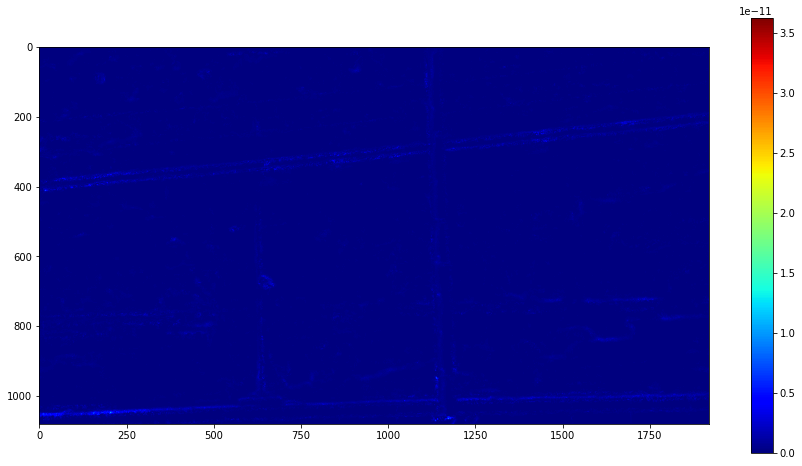

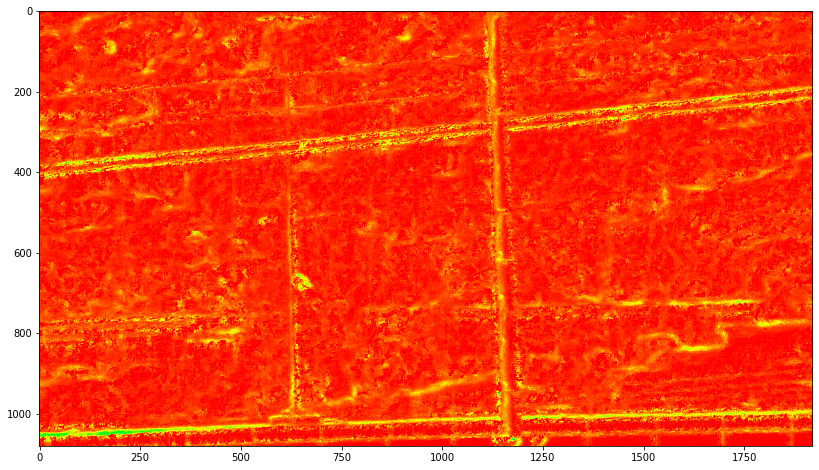

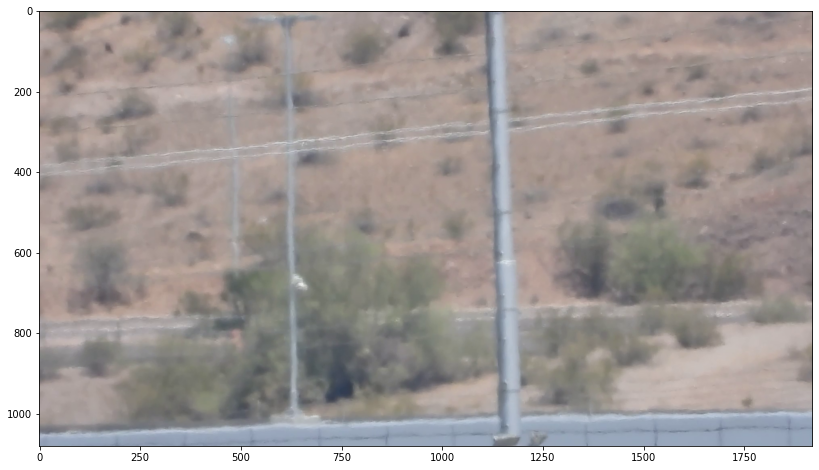

In [23]:
# Replace np.nan with 0
Cn_sqr_mnMap = np.nan_to_num(Cn_sqr_mn, nan=0)
Cn_sqr_mnMap = np.mean(Cn_sqr_mnMap, axis=2) # (1080, 1920)

Normalize = lambda x: (x - np.min(x)) / (np.max(x) - np.min(x))
plt.imshow((Cn_sqr_mnMap), cmap='jet'), plt.colorbar(), plt.show();

sq_Cn_sqr_mnMap = np.sqrt(Cn_sqr_mnMap)
plt.imshow(sq_Cn_sqr_mnMap, cmap='hsv'), plt.show();

plt.imshow(video[0][:,:,::-1]), plt.show();

### Overlay the $C_n^2$ Map on the Image

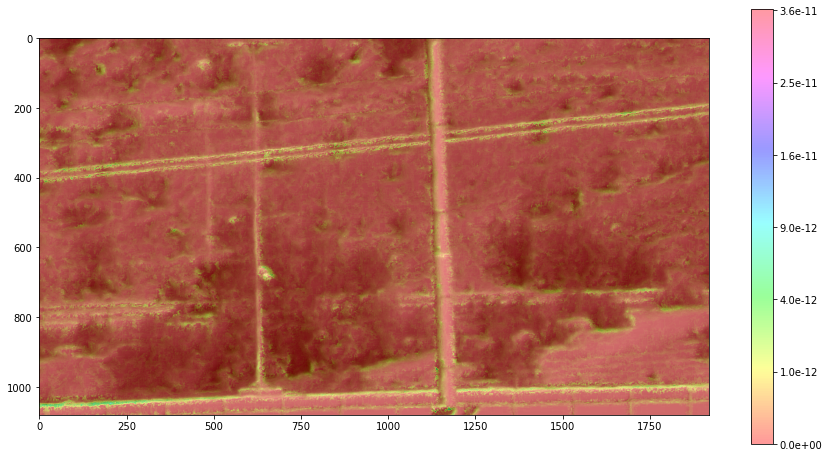

In [9]:
plt.figure(figsize=(15,8))
plt.imshow(video[0][:,:,0], cmap='gray')
plt.imshow(sq_Cn_sqr_mnMap, cmap='hsv', alpha=0.4, interpolation='bilinear')

cbar = plt.colorbar()
def square(x, pos):
    return '%0.1e' % (x ** 2)
formatter = FuncFormatter(square)
cbar.ax.yaxis.set_major_formatter(formatter)
plt.show()